In [1]:
%matplotlib notebook

import torch
import fnmatch
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.datasets as datasets

from network import Network
from hessian import Hessian
from utils import get_mean_std
from sklearn.manifold import TSNE
from torchvision import transforms
from torch.utils.data import DataLoader
from subset_dataset import get_subset_dataset
from models import model_urls, download_model

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
#%% Parameters

dataset = [
#     'MNIST'
#     'FashionMNIST',
    'CIFAR10',
#     'CIFAR100',
][0]

net = [
#     'VGG11_bn',
    'ResNet18',
#     'DenseNet3_40'
][0]

examples_per_class = [
    10,
#     13,
#     19,
#     26,
#     37,
#     51,
#     71,
#     98,
#     136,
#     189,
#     263,
#     365,
#     506,
#     702,
#     974,
#     1351,
#     1874,
#     2599,
#     3605,
#     5000
][0]

batch_size = 1024

In [3]:
#%% Download model and its corresponding meta data from GCP bucket

# URL pattern
pattern = 'https://storage.googleapis.com/hs-deep-lab-donoho-papyan-bucket/'  \
        + 'trained_models/*/*/results/'                                       \
        + 'dataset=' + dataset                                                \
        + '-net=' + net                                                       \
        + '-lr=*'                                                             \
        + '-examples_per_class=' + str(examples_per_class)                    \
        + '-num_classes=*'                                                    \
        + '-epc_seed=*'                                                       \
        + '-train_seed=*'                                                     \
        + '-epoch=*'                                                          \
        + '.pth'

# Find URL from list of model urls
model_url = fnmatch.filter(model_urls, pattern)[0]

# Download model and its corresponding meta data from URL
model_path, results_path = download_model(model_url)

# Read CSV
df = pd.read_csv(results_path)

# First row in CSV, which contains different parameters
row = df.iloc[0]

In [4]:
#%% Network

# Initialize network
model = Network().construct(net, row)
model = model.eval()

# Load trained model
state_dict = torch.load(model_path, map_location=lambda storage, loc: storage)
model.load_state_dict(state_dict, strict=False)
model = model.to(device)

gpus = torch.cuda.device_count()
if gpus > 1:
    print("Let's use", gpus, "GPUs!")
    model = nn.DataParallel(model, device_ids=range(gpus))

Let's use 4 GPUs!


In [5]:
#%% Dataset

# Transform
mean, std = get_mean_std(dataset)
pad = int((row.padded_im_size-row.im_size)/2)
transform = transforms.Compose([transforms.Pad(pad),
                                transforms.ToTensor(),
                                transforms.Normalize(mean,std)])

# Subsampled dataset
full_dataset = getattr(datasets, dataset)
subset_dataset = get_subset_dataset(full_dataset=full_dataset,
                                    examples_per_class=examples_per_class,
                                    epc_seed=row.epc_seed,
                                    root='data/',
                                    train=True,
                                    transform=transform,
                                    download=True)

# Loader
loader = DataLoader(dataset=subset_dataset,
                    drop_last=False,
                    batch_size=batch_size)

Files already downloaded and verified


In [6]:
#%% G decomposition

C = row.num_classes

res = Hessian(crit='CrossEntropyLoss',
              loader=loader,
              device=device,
              model=model,
              num_classes=C,
              hessian_type='G',
              ).compute_G_decomp()

Computing delta_{c,c'}
Iteration: [1/1]
Computing delta_c
Computing distances for t-SNE plot
Iteration: [1/110]
Iteration: [2/110]
Iteration: [3/110]
Iteration: [4/110]
Iteration: [5/110]
Iteration: [6/110]
Iteration: [7/110]
Iteration: [8/110]
Iteration: [9/110]
Iteration: [10/110]
Iteration: [11/110]
Iteration: [12/110]
Iteration: [13/110]
Iteration: [14/110]
Iteration: [15/110]
Iteration: [16/110]
Iteration: [17/110]
Iteration: [18/110]
Iteration: [19/110]
Iteration: [20/110]
Iteration: [21/110]
Iteration: [22/110]
Iteration: [23/110]
Iteration: [24/110]
Iteration: [25/110]
Iteration: [26/110]
Iteration: [27/110]
Iteration: [28/110]
Iteration: [29/110]
Iteration: [30/110]
Iteration: [31/110]
Iteration: [32/110]
Iteration: [33/110]
Iteration: [34/110]
Iteration: [35/110]
Iteration: [36/110]
Iteration: [37/110]
Iteration: [38/110]
Iteration: [39/110]
Iteration: [40/110]
Iteration: [41/110]
Iteration: [42/110]
Iteration: [43/110]
Iteration: [44/110]
Iteration: [45/110]
Iteration: [46/1

<IPython.core.display.Javascript object>


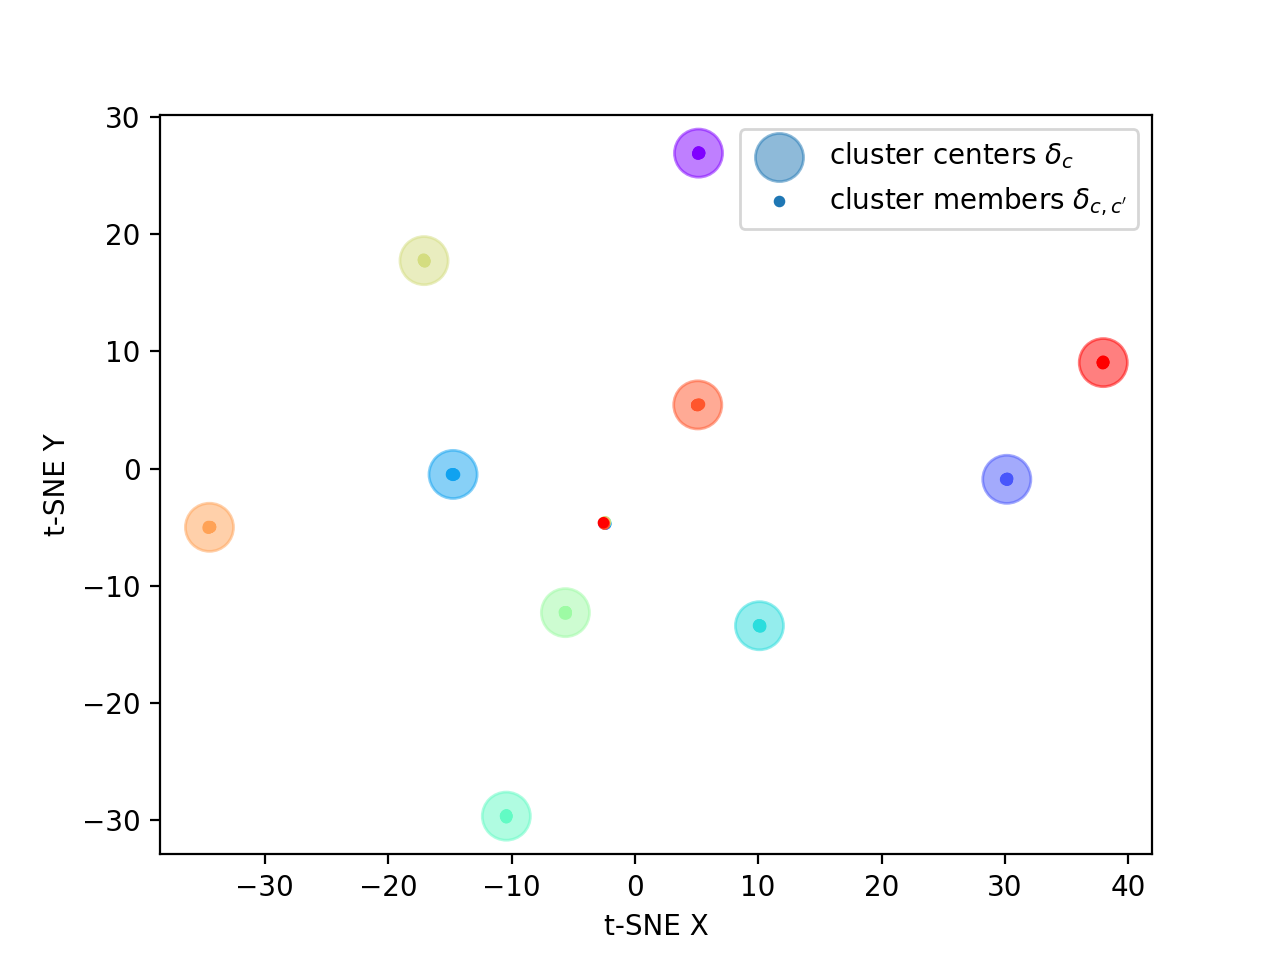

In [7]:
#%% t-SNE plot of {delta_c}_c and {delta_{c,c'}}_{c,c'} (Figure 3 in the paper)

# res['dist'] is a (C+C^2)x(C+C^2) distance matrix
# First C indices correspond to {delta_c}_c
# Last C^2 indices correspond to {delta_{c,c'}}_{c,c'}

# Compute t-SNE embedding uing the distance matrix
tsne_embedded = TSNE(n_components=2,
                     metric='precomputed',
                     perplexity=C).fit_transform(res['dist'])

# t-SNE X
delta_c_X = tsne_embedded[:C,0]
delta_ccp_X = tsne_embedded[C:,0]

# t-SNE Y
delta_c_Y = tsne_embedded[:C,1]
delta_ccp_Y = tsne_embedded[C:,1]

# True class c is in the first entry of res['labels']
c = [x[0] for x in res['labels']]
delta_c_C = c[:C]
delta_ccp_C = c[C:]

plt.figure()

plt.scatter(delta_c_X,   delta_c_Y,   c=delta_c_C,   s=300, cmap=plt.get_cmap('rainbow'), label='cluster centers $\delta_c$', alpha=0.5)
plt.scatter(delta_ccp_X, delta_ccp_Y, c=delta_ccp_C, s=10,  cmap=plt.get_cmap('rainbow'), label="cluster members $\delta_{c,c'}$")

plt.xlabel('t-SNE X')
plt.ylabel('t-SNE Y')

plt.legend()

In [8]:
#%% Hessian computations
Hess = Hessian(crit='CrossEntropyLoss',
               loader=loader,
               device=device,
               model=model,
               num_classes=C,
               hessian_type='G',
               init_poly_deg=64,     # number of iterations used to compute maximal/minimal eigenvalue
               poly_deg=128,         # the higher the parameter the better the approximation
               spectrum_margin=0.05,
               poly_points=1024,     # number of points in spectrum approximation
               SSI_iters=128,        # iterations of subspace iterations
               )

# Spectrum approximation using Lanczos
eigval, eigval_density = Hess.LanczosLoop(denormalize=True)

# Exact outliers computation using subspace iteration
_, SSI_eigvals, _ = Hess.SubspaceIteration()

Lanczos Method
Iteration: [1/64]
Iteration: [2/64]
Iteration: [3/64]
Iteration: [4/64]
Iteration: [5/64]
Iteration: [6/64]
Iteration: [7/64]
Iteration: [8/64]
Iteration: [9/64]
Iteration: [10/64]
Iteration: [11/64]
Iteration: [12/64]
Iteration: [13/64]
Iteration: [14/64]
Iteration: [15/64]
Iteration: [16/64]
Iteration: [17/64]
Iteration: [18/64]
Iteration: [19/64]
Iteration: [20/64]
Iteration: [21/64]
Iteration: [22/64]
Iteration: [23/64]
Iteration: [24/64]
Iteration: [25/64]
Iteration: [26/64]
Iteration: [27/64]
Iteration: [28/64]
Iteration: [29/64]
Iteration: [30/64]
Iteration: [31/64]
Iteration: [32/64]
Iteration: [33/64]
Iteration: [34/64]
Iteration: [35/64]
Iteration: [36/64]
Iteration: [37/64]
Iteration: [38/64]
Iteration: [39/64]
Iteration: [40/64]
Iteration: [41/64]
Iteration: [42/64]
Iteration: [43/64]
Iteration: [44/64]
Iteration: [45/64]
Iteration: [46/64]
Iteration: [47/64]
Iteration: [48/64]
Iteration: [49/64]
Iteration: [50/64]
Iteration: [51/64]
Iteration: [52/64]
Iterat

<IPython.core.display.Javascript object>


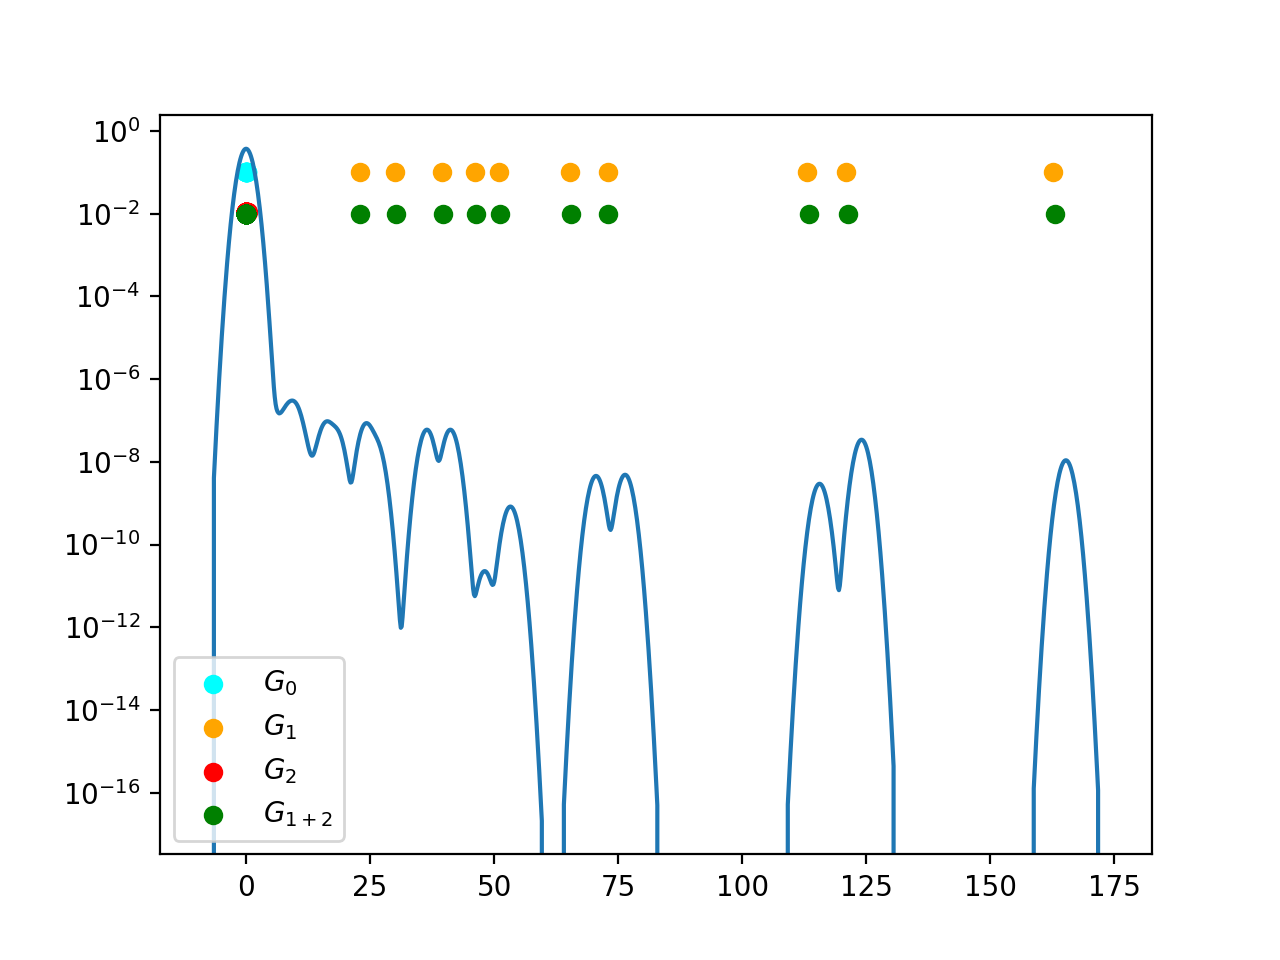

In [9]:
#%% Approximate spectrum of G and the eigenvalues of G0, G1, G2 and G1+2 (Figure 10 in the paper)

plt.figure()

plt.semilogy(eigval, eigval_density)

plt.scatter(res['G0_eigval'],  res['G0_eigval_density'],  c='cyan',   label='$G_0$')
plt.scatter(res['G1_eigval'],  res['G1_eigval_density'],  c='orange', label='$G_1$')
plt.scatter(res['G2_eigval'],  res['G2_eigval_density'],  c='red',    label='$G_2$')
plt.scatter(res['G12_eigval'], res['G12_eigval_density'], c='green',  label='$G_{1+2}$')

plt.legend()

<IPython.core.display.Javascript object>


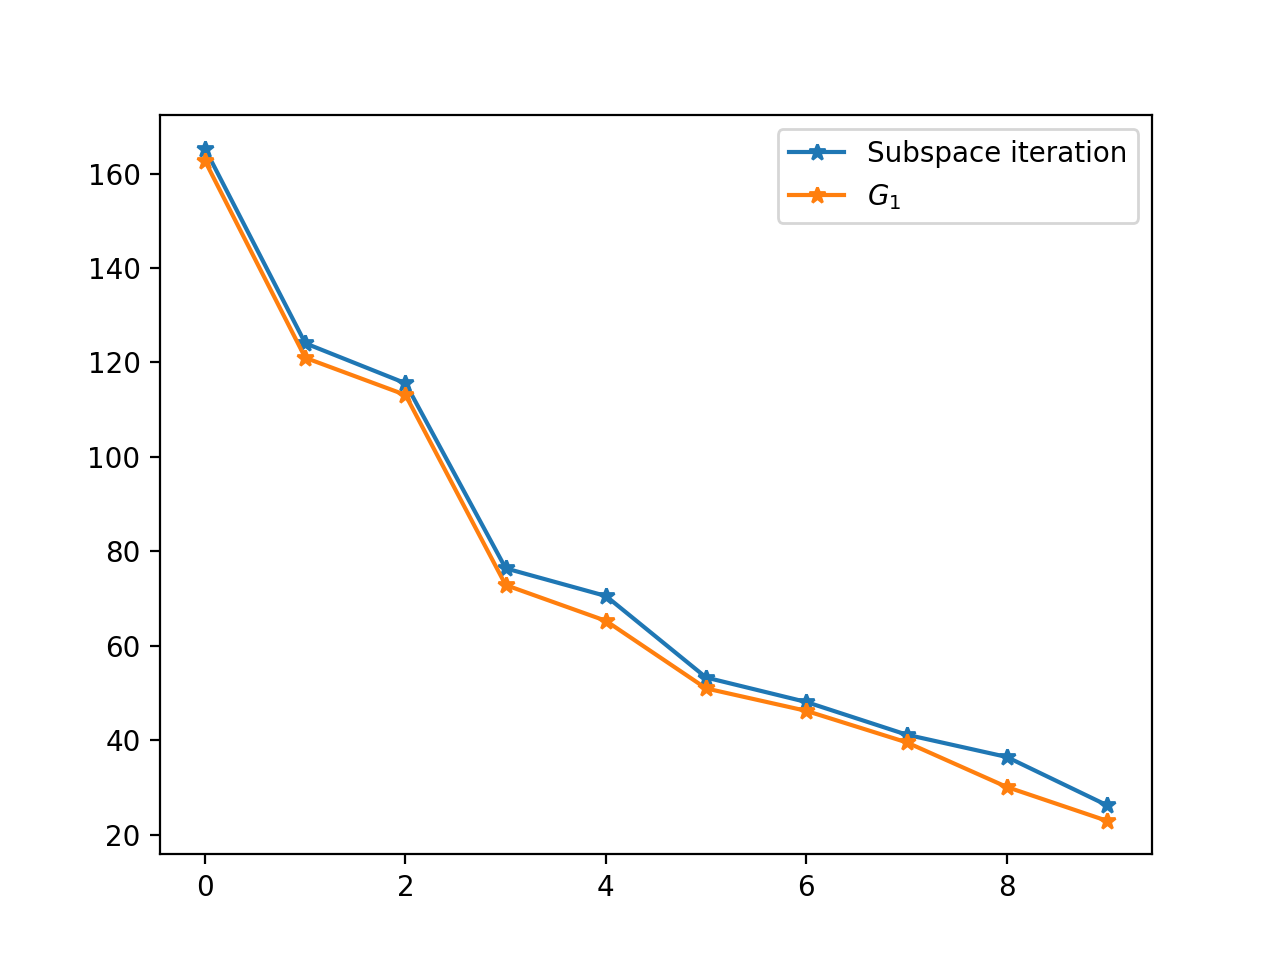

In [10]:
#%% Outliers estimated using subspace iteration versus eigenvalues of G1 (Figure 1 in the Appendix)

plt.figure()

plt.plot(np.arange(len(SSI_eigvals)),      SSI_eigvals,      '-*', label='Subspace iteration')
plt.plot(np.arange(len(res['G1_eigval'])), res['G1_eigval'], '-*', label='$G_1$')

plt.legend()
plt.show()